In [1]:
from enviroments import env_red_toy3
import numpy as np

In [2]:
env = env_red_toy3("Exp", T =30)
print(env.C)

C = 10
T = 30

[10 10]


In [3]:
from itertools import product

seats = []
for i in range(len(env.C)):
    seats.append(np.arange(0, C + 1))   
time = np.arange(0, T)

states_map = {}
for idx, s in enumerate(product(*seats, time)):
    states_map[s] = idx

In [4]:
len(states_map)

3630

In [5]:
def integer_to_binary_tuple(integer, word_size):
    # Obtener la representación binaria del número entero sin el prefijo '0b'
    binary_str = bin(integer)[2:]

    # Asegurarse de que la cadena binaria tenga el tamaño deseado llenando con ceros a la izquierda si es necesario
    binary_str = binary_str.zfill(word_size)

    # Crear una tupla con cada bit del número binario
    binary_tuple = tuple(int(bit) for bit in binary_str)

    return binary_tuple

In [6]:
def comparar_vectores(vector1, vector2):
    # Verificar si los vectores tienen la misma longitud
    if len(vector1) != len(vector2):
        return False
    
    # Comparar los elementos de los vectores entrada a entrada
    for elem1, elem2 in zip(vector1, vector2):
        if elem1 == elem2:
            return False
    
    # Si todos los elementos son iguales, devolver True
    return True

In [7]:
def obtener_tupla_desde_indice(indice, states_map):
    for tupla, idx in states_map.items():
        if idx == indice:
            return tupla

In [8]:
nS = len(states_map)
nA = 2**(env.J)

lambd = 0.3

P_sa_s = np.zeros((nS, nA, nS))

for idx, s in enumerate(product(*seats, time)):
    for a in range(nA):
        #Cambiar p_llegada para que se variable con t
        #print(p_j[list(a)].sum())
        if a == 0 and s[-1] != (T-1):
            idx_1 = states_map[(*(s[:-1]), s[-1] + 1)]
            P_sa_s[idx, a, idx_1] = 1
        else:
            for j, p_j in enumerate(env.P_j_dist(integer_to_binary_tuple(a, env.J))):
                if j == 0:
                    s_prime = (*(s[:-1]), s[-1] + 1)
                else:
                     s_prime =(*(s[:-1] + np.squeeze(np.transpose(env.A_ij[:,j-1]))), s[-1] + 1)
                if comparar_vectores(s_prime,(C+1,C+1,T)):
                    idx_1 = states_map[s_prime]
                    P_sa_s[idx, a, idx_1] += p_j

        


In [9]:
for j in range(env.J):
    print(np.squeeze(np.transpose(env.A_ij[:,j-1])))

[1 1]
[1 0]
[0 1]


In [10]:
for ids, p in enumerate(P_sa_s[states_map[(9,9,7)],7,:]):
    if p != 0:
        print(obtener_tupla_desde_indice(ids, states_map))
        print(p)

(9, 10, 8)
0.3333333333333333
(10, 9, 8)
0.3333333333333333
(10, 10, 8)
0.3333333333333333


In [11]:
a = integer_to_binary_tuple(3, env.J)
print(tuple(a))
print(env.P_j_dist(a))

(0, 1, 1)
[0.33333333 0.         0.33333333 0.33333333]


In [12]:
R_sa = np.zeros((nS,nA))

for idx, s in enumerate(product(*seats, time)):
    for a in range(nA):
        #Cambiar p_llegada para que se variable con t
        #print(p_j[list(a)].sum())
        if a == 0 and s[-1] != (T-1):
            R_sa[idx, a] = 0
        else:
            expected_revenue = 0
            for j, p_j in enumerate(env.P_j_dist(integer_to_binary_tuple(a, env.J))):
                if j == 0:
                    s_prime = (*(s[:-1]), s[-1] + 1)
                else:
                    s_prime =(*(s[:-1] + np.squeeze(np.transpose(env.A_ij[:,j-1]))), s[-1] + 1)
                    if comparar_vectores(s_prime,(C+1,C+1,T)):
                        idx_1 = states_map[s_prime]
                        expected_revenue += p_j*env.r_j[j-1]
            R_sa[idx, a] = expected_revenue


In [13]:
gamma = 1

def policy_evaluation(Pi):
    P_s_s = np.einsum('ijk, ij -> ik', P_sa_s, Pi)
    R_s = np.einsum('ij, ij -> i', R_sa, Pi)
    
    V = np.zeros(nS)
    for _ in range(100):
        V = R_s + gamma * P_s_s @ V
        
    Q = R_sa + gamma * P_sa_s @ V
    return V, Q

def policy_improvement(Q):
    Pi = np.zeros((nS, nA))
    for s in range(nS):
        a = np.argmax(Q[s, :])
        Pi[s, a] = 1
    return Pi

V_old = np.zeros(nS)
Q_old = np.zeros((nS, nA))
Pi = np.random.rand(nS, nA)
Pi /= Pi.sum(axis=1, keepdims=True)
error_plicy = []
for _ in range(30):
    V, Q = policy_evaluation(Pi)
    Pi = policy_improvement(Q)

    #print(V)
    #assert np.all(V >= V_old)
    #assert np.all(Q >= Q_old)
    
    error_plicy.append(np.linalg.norm(V - V_old))
    V_old = V
    Q_old = Q

V_policy = V

KeyboardInterrupt: 

In [14]:
V_old = np.zeros(nS)
error_value = []
gamma = 1
for _ in range(60):
    V = np.max(R_sa + gamma * P_sa_s @ V_old, axis=1)
    assert np.all(V >= V_old)
    error_value.append(np.linalg.norm(V - V_old))
    V_old = V
V_value = V

Q = R_sa + gamma * P_sa_s @ V

In [15]:
print(Q[states_map[(0,0,0)],:])
print(R_sa[states_map[(9,9,7)],:])
for ids, p in enumerate(P_sa_s[states_map[(9,9,7)],7,:]):
    if p != 0:
        print(obtener_tupla_desde_indice(ids, states_map))
        print(p)
        
print(int(np.argmax(Q[states_map[(9,9,7)],:])))

[1757.50006305 1753.12828462 1771.10739658 1766.73561814 1771.10739658
 1766.73561814 1784.71473011 1780.34295167]
[  0.          33.33333333  33.33333333  66.66666667  33.33333333
  66.66666667  66.66666667 100.        ]
(9, 10, 8)
0.3333333333333333
(10, 9, 8)
0.3333333333333333
(10, 10, 8)
0.3333333333333333
6


In [ ]:
def select_action(Q_tensor, s,states_map):
    return int(np.argmax(Q_tensor[states_map[tuple(s)],:]))


In [ ]:
env = env_red_toy3(model="Exp",T =30)
num_sim = 1000
max_steps = env.T

Rs = []
R_t= []
S_sf = []
Num_politicas = 4

for p in range(Num_politicas):
    rs = []
    s_t = []
    r_t = []
    s_sf = []
    for episode in range(num_sim):
        s, _ = env.set_initial(s = [0]*env.I)
        R = 0
        for step in range(max_steps):

            if p == 0:
                a = [1,1,0]
            elif p == 1:
                a = [1,1,1]
            elif p == 2:
                a = list(np.random.choice([0, 1], size=3))
            elif p == 3:
                a = select_action(Q, s,states_map)
            
            s_prime, r, done, _, _ = env.step(a)
   
            r_t.append(r)
            s_t.append(s)

            R += r

            if done:
                S = s_prime
                break
            s = s_prime    
        rs.append(R)
        s_sf.append(S)
    S_sf.append(s_sf)
    Rs.append(rs)

[28.711, 20.414, 28.495, 28.698]
[1766.1, 1551.3, 1293.4, 1771.5]


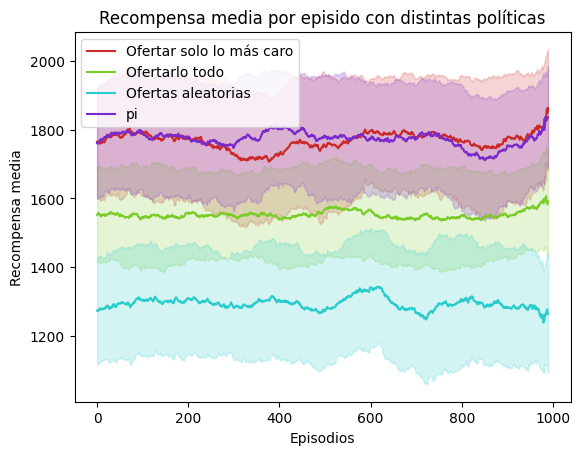

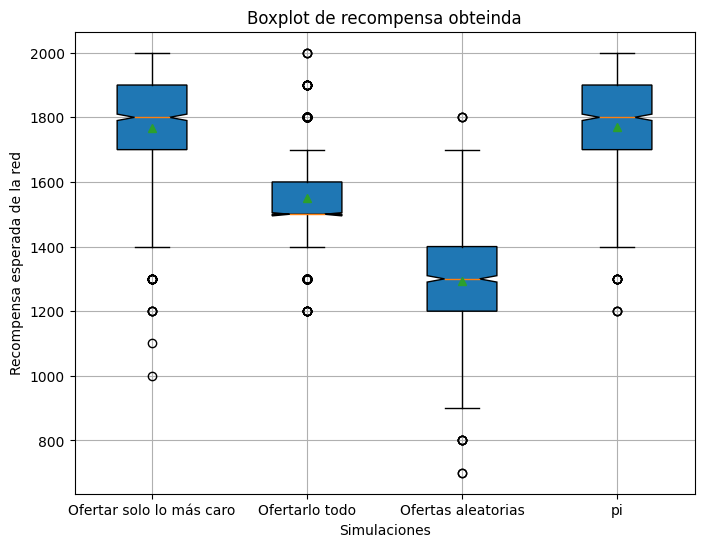

In [ ]:
from algorithms.utils import generate_random_colors
import matplotlib.pyplot as plt

colors = generate_random_colors(Num_politicas)
etiqueta =  ["Ofertar solo lo más caro", "Ofertarlo todo", "Ofertas aleatorias","pi"]

for p in range(Num_politicas):
    
    totals = Rs[p]
    x = np.array(totals).ravel()

    mean = np.array([np.mean(x[i:i+100]) for i in range(len(x) - 10)])
    std = np.array([np.std(x[i:i+100]) for i in range(len(x) - 10)])
    time = np.arange(mean.size)
    plt.plot(mean,color=colors[p],label = etiqueta[p])
    #plt.plot(Rsim, color = 'r')
    plt.fill_between(time, mean - std, mean + std, color=colors[p], alpha=0.2)
    plt.title("Recompensa media por episido con distintas políticas")
    plt.xlabel('Episodios')
    plt.ylabel('Recompensa media')
    plt.legend()
    

T_tf_mean = []
for i in range(Num_politicas):
    t_tf = []
    for x in S_sf[i]:
        t_tf.append(x[2])
    T_tf_mean.append(np.mean(t_tf))

print(T_tf_mean)

Rs_f_mean = []
for i in range(Num_politicas):
    Rs_f_mean.append(np.mean(Rs[i]))

print(Rs_f_mean)

datos = Rs
plt.figure(figsize=(8, 6))
plt.boxplot(datos, patch_artist=True, notch=True, showmeans=True)

plt.title('Boxplot de recompensa obteinda')
plt.xlabel('Simulaciones')
plt.ylabel('Recompensa esperada de la red')
plt.xticks(range(1,Num_politicas+1),etiqueta)  # Cambiar etiquetas del eje x
plt.grid(True)
plt.show()


In [ ]:
np.mean(Rs[3])

1771.5